In [2]:
from sklearn.metrics                 import confusion_matrix, plot_confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection         import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.feature_selection       import chi2, SelectKBest
from sklearn.linear_model            import LogisticRegression
from sklearn.naive_bayes             import MultinomialNB,ComplementNB
from imblearn.pipeline               import Pipeline, make_pipeline
from imblearn.over_sampling          import SMOTE, ADASYN
from sklearn.utils                   import class_weight
from sklearn                         import preprocessing
from collections                     import Counter
from sklearn                         import metrics

import matplotlib.pyplot             as plt
import numpy                         as np
import pandas                        as pd
import re

df =  pd.read_csv(r'/work/NLP/Assignment-2/emotions.csv')

labels = df.Label.unique()
counter = Counter(df.Label)
print(counter)

df.head()

Counter({'Trust': 1159, 'Anticipation': 928, 'Sadness': 357, 'Disgust': 293, 'Joy': 279, 'Surprise': 156, 'Fear': 129, 'Anger': 85})


,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Trust,Emotions,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Disgust,Emotions,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Trust,Emotions,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Disgust,Emotions,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Disgust,Emotions,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


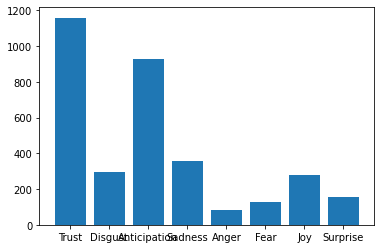

In [3]:
# Evidently dealing with imbalanced data. Lets visualize the label distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [4]:
# This class imbalance needs to be handled in order to construct a good model
# We will first continue by cleaning the data
import nltk
def preprocess(text):
    
    txt = re.sub(r'[-.,;:!?\'\d+]+', "", str(text).lower().strip())
    tokens = txt.split()
    
    stemmer = nltk.stem.porter.PorterStemmer()
    lst_text = [stemmer.stem(word) for word in tokens]
    
    output = " ".join(lst_text)
    return output

df["text_clean"] = df["discussion_text"].apply(lambda x: preprocess(x))
df.tail(6)["text_clean"]

3380    it depend on how you view it jenni ruhl for in...
3381    it doe have a black box warn victoza victoza t...
3382    it doe not answer the fact that my intern gluc...
3383    it doe not matter how much or what time i eat ...
3384    it doesnt includ type s of cours as well as ty...
3385    it doesnt look to me like your diabet (judg fr...
Name: text_clean, dtype: object

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.text_clean, df.Label,
                                                                        test_size = 0.2,
                                                                        random_state = 42,
                                                                        shuffle = True,
                                                                        stratify = df.Label)
print(X_train.shape)
print(X_test.shape)

print(Counter(y_train))
print(Counter(y_test))
# train_test showns to preserve label distribution ratio

(2708,)
(678,)
Counter({'Trust': 927, 'Anticipation': 742, 'Sadness': 286, 'Disgust': 234, 'Joy': 223, 'Surprise': 125, 'Fear': 103, 'Anger': 68})
Counter({'Trust': 232, 'Anticipation': 186, 'Sadness': 71, 'Disgust': 59, 'Joy': 56, 'Surprise': 31, 'Fear': 26, 'Anger': 17})


In [6]:
# Given the class imbalance we have decided to utilize the ADASYN algorithm
# Accuracy fell, but recall improved. 
# This makes sense since the model would be more biased towards the majority class

adasyn = ADASYN(sampling_strategy = 'minority', random_state = 42)

logistic_model = Pipeline([
    ('vect', CountVectorizer(stop_words = 'english',
                             ngram_range = (1,4), 
                             max_features = 20000)),
    
    ('tfidf', TfidfTransformer()),
    ('sampler', adasyn),
    ('clf', LogisticRegression(solver='sag', max_iter = 10000, multi_class='multinomial')),
     ])

MNB_model = Pipeline(
    [('vect', CountVectorizer(stop_words = 'english',
                              ngram_range = (1,4),
                              max_features = 20000
                              )),
     ('tfidf', TfidfTransformer()),
     ('sampler', adasyn),
     ('clf', MultinomialNB()),
     ])

In [7]:
emotions_log_clf = logistic_model.fit(X_train, y_train)
emotions__log_pred = logistic_model.predict(X_test)

emotions_MNB_clf = MNB_model.fit(X_train, y_train)
emotions_MNB_pred = MNB_model.predict(X_test)

In [8]:
# Accuracy scores
emotions_log_acc = accuracy_score(y_test, emotions__log_pred)
emotions_MNB_acc = accuracy_score(y_test, emotions_MNB_pred)

print('Accuracy for logistic model:', emotions_log_acc)
print('Accuracy for MNB model:', emotions_MNB_acc)

Accuracy for logistic model: 0.2581120943952802
Accuracy for MNB model: 0.26253687315634217


In [9]:
# Classification reports
emotions_logistic_report = metrics.classification_report(y_test, 
                                                         emotions__log_pred, 
                                                         target_names = labels)

emotions_MNB_report = metrics.classification_report(y_test, 
                                                    emotions_MNB_pred, 
                                                    target_names = labels)

print('Classification report for logistic model:\n', emotions_logistic_report)
print('Classification report for MNB model:\n', emotions_MNB_report)

Classification report for logistic model:
               precision    recall  f1-score   support

       Trust       0.00      0.00      0.00        17
     Disgust       0.19      0.22      0.20       186
Anticipation       0.00      0.00      0.00        59
     Sadness       0.00      0.00      0.00        26
       Anger       0.00      0.00      0.00        56
        Fear       0.00      0.00      0.00        71
         Joy       0.00      0.00      0.00        31
    Surprise       0.31      0.58      0.40       232

    accuracy                           0.26       678
   macro avg       0.06      0.10      0.08       678
weighted avg       0.16      0.26      0.19       678

Classification report for MNB model:
               precision    recall  f1-score   support

       Trust       0.03      0.24      0.06        17
     Disgust       0.02      0.01      0.01       186
Anticipation       0.00      0.00      0.00        59
     Sadness       0.00      0.00      0.00        

In [10]:
# Start of Patient Journey dataset
df_2 = pd.read_csv(r'/work/NLP/Assignment-2/Diabetes-classi.csv')


labels_2 = df_2.Label.unique()
counter_2 = Counter(df.Label)
print(counter)

df_2.head()

Counter({'Trust': 1159, 'Anticipation': 928, 'Sadness': 357, 'Disgust': 293, 'Joy': 279, 'Surprise': 156, 'Fear': 129, 'Anger': 85})


,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Living with diabetes - Nutrition,Patient Journey,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Living with diabetes - Nutrition,Patient Journey,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Undiagnosed,Patient Journey,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Living with diabetes - Nutrition,Patient Journey,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Clinical Treatment,Patient Journey,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


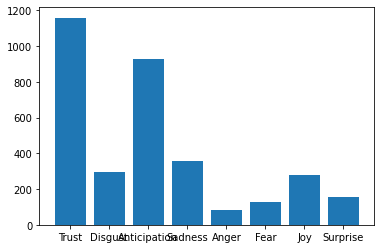

In [11]:
# Visualizing label distribution
plt.bar(counter_2.keys(), counter_2.values())
plt.show()

In [12]:
# Applying preprocess function on text column
df_2["text_clean"] = df_2["discussion_text"].apply(lambda x: preprocess(x))
df_2.tail(6)["text_clean"]

1420    i am do thi for myself and to help my health y...
1421    i am extrem glad i found thi forum and all you...
1422    i am fairli newli diagnos with type diabet whi...
1423    i am fairli newli diagnos with type diabet whi...
1424    i am go through the same thing right now i had...
1425    i am go to ask my doctor for a fast insulin te...
Name: text_clean, dtype: object

In [13]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_2.text_clean, df_2.Label,
                                                                        test_size = 0.2,
                                                                        random_state = 42,
                                                                        shuffle = True,
                                                                        stratify = df_2.Label)
print(Counter(y_train_2))
print(Counter(y_test_2))

Counter({'Living with diabetes - Nutrition': 335, 'Living with diabetes - Lifestyle; Social and Psychological': 231, 'Clinical Treatment': 177, 'Undiagnosed': 150, 'Living with diabetes - Exercise': 148, 'Diagnosis ': 47, 'Relatives of diabetes patients': 41, 'Alternative Treatment': 11})
Counter({'Living with diabetes - Nutrition': 84, 'Living with diabetes - Lifestyle; Social and Psychological': 58, 'Clinical Treatment': 45, 'Undiagnosed': 37, 'Living with diabetes - Exercise': 37, 'Diagnosis ': 12, 'Relatives of diabetes patients': 10, 'Alternative Treatment': 3})


In [14]:
patientJourney_log_clf = logistic_model.fit(X_train_2, y_train_2)
patientJourney_log_pred = logistic_model.predict(X_test_2)

patientJourney_MNB_clf = MNB_model.fit(X_train_2, y_train_2)
patientJourney_MNB_pred = MNB_model.predict(X_test_2)

In [15]:
patientJourney_log_acc = accuracy_score(y_test_2, patientJourney_log_pred)
patientJourney_MNB_acc = accuracy_score(y_test_2, patientJourney_MNB_pred)

print('Accuracy for logistic model:', patientJourney_log_acc)
print('Accuracy for MNB model:', patientJourney_MNB_acc)

Accuracy for logistic model: 0.458041958041958
Accuracy for MNB model: 0.2972027972027972


In [16]:
patientJourney_logistic_report = metrics.classification_report(y_test_2, 
                                                         patientJourney_log_pred, 
                                                         target_names = labels_2)

patientJourney_MNB_report = metrics.classification_report(y_test_2, 
                                                    patientJourney_MNB_pred, 
                                                    target_names = labels_2)

print('Classification report for logistic model:\n', patientJourney_logistic_report)
print('Classification report for MNB model:\n', patientJourney_MNB_report)

Classification report for logistic model:
                                                             precision    recall  f1-score   support

                          Living with diabetes - Nutrition       0.00      0.00      0.00         3
                                               Undiagnosed       0.54      0.49      0.51        45
                                        Clinical Treatment       0.00      0.00      0.00        12
                            Relatives of diabetes patients       0.53      0.27      0.36        37
Living with diabetes - Lifestyle; Social and Psychological       0.38      0.31      0.34        58
                           Living with diabetes - Exercise       0.46      0.89      0.60        84
                                     Alternative Treatment       0.00      0.00      0.00        10
                                                Diagnosis        0.43      0.16      0.24        37

                                                  accur

Text(0.5, 1.0, 'Word Matrix')

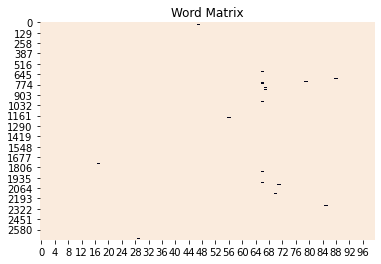

In [17]:
# Feature matrix has a shape of 2708 documents (number of rows in splitted df) and 10k features
# Converting Series object to equivalent pipeline vectors in order to visualize. 
import seaborn as sns
vectorizer = TfidfVectorizer(stop_words = "english",
                             ngram_range = (1, 4))

X_viz = vectorizer.fit_transform(X_train)

    
sns.heatmap(X_viz.todense()[:,np.random.randint(0, 
                                X_viz.shape[1], 
                                100)]==0, 
                                vmin=0, 
                                vmax=1, 
                                cbar=False).set_title('Word Matrix')

The low accuracy scores can be attributed to the fact that even though we accounted for the class imbalance through ADASYN, the algorithm does not perform well on sparse matrices (since it incorporates KNN), which our dataset becomes after vectorization, as vizualised in the above cell. The solution to this is to first perform feature selection and then pass the select key features to the models.

Furthermore it can be said that, surprisingly, our logistic regression classifier perfoms better on the smaller dataset than the Multinomial Naive Bayes. We expected Naive Bayes to outperform Logistic Regression in the patient journey dataset and the opposite for the emotions dataset. Our assumptions were based on current research. According to professor Andrew Ng in his paper, On Discriminative vs. generative Classifiers: A comparison of logistic regression and naive Bayes, when the training size is larger logistic regression performs better than Naive Bayes. But this wasn't the case in our attempt. This is due to the above-mentioned fact that the datasets are converted to sparse matrices and as such, the smaller dataset will naturally be less sparse and so logistic regression in the end performs better here.

In [18]:
#Extract most informative features used by the classifiers 
#for the classification of labels in the case of both models
def extract_most_informative_features(X_train, y_train, met, n):
    #CountVectorizer
    count_vectorize = CountVectorizer(stop_words='english',max_features=100)
    X_train_count = count_vectorize.fit_transform(raw_documents = X_train)
    #TfidfTransformer
    tfidf_transformer = TfidfTransformer(use_idf=True).fit(X_train_count)
    X_train_tfidf = tfidf_transformer.transform(X_train_count)
    #Classification method
    met.fit(X_train_tfidf, y_train)
    #Features
    feature_names = count_vectorize.get_feature_names()
    feat_importances = pd.Series(met.coef_[0], feature_names )
    #Sort
    result = feat_importances.nlargest(n)
    return(result)

In [19]:
#Multinomial NB & Logistic Regression method
MultiNB = MultinomialNB()
LogReg =  LogisticRegression()
print("The following are the most useful characteristics of the Multinomial Naive Bayes Classifier (Emotion Dataset):")
display(extract_most_informative_features(X_train, y_train, MultiNB, 10))
print("Logistic Regression Classification's Most Insightful Features (Emotion Dataset):")
display(extract_most_informative_features(X_train, y_train, LogReg, 10))

The following are the most useful characteristics of the Multinomial Naive Bayes Classifier (Emotion Dataset):
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


diabet    -3.308109
type      -3.540531
wa        -3.758217
year      -3.972874
thi       -4.076944
ha        -4.093779
hi        -4.127367
insulin   -4.130899
just      -4.196800
diagnos   -4.205825
dtype: float64

ogistic Regression Classification's Most Insightful Features (Emotion Dataset):


low        0.973943
did        0.965733
normal     0.959839
exercis    0.791376
sinc       0.671849
feel       0.670969
health     0.664449
diseas     0.648585
good       0.640344
read       0.639896
dtype: float64

In [20]:
print("The following are the most useful characteristics of the Multinomial Naive Bayes Classifier (Patient Journey):")
display(extract_most_informative_features(X_train_2, y_train_2, MultiNB,10))
print("The Most Insightful Logistic Regression Classification Features (Patient Journey):")
display(extract_most_informative_features(X_train_2, y_train_2, LogReg, 10))

The following are the most useful characteristics of the Multinomial Naive Bayes Classifier (Patient Journey):
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


diabet    -3.735424
recent    -3.958851
just      -4.075983
type      -4.103511
use       -4.125294
help      -4.161780
lower     -4.173802
insulin   -4.180217
hi        -4.187985
medic     -4.189772
dtype: float64

The Most Insightful Logistic Regression Classification Features (Patient Journey):


recent     1.112643
lower      0.844915
use        0.691963
just       0.678894
patient    0.660405
medic      0.629978
help       0.571381
result     0.489075
new        0.483926
loss       0.476870
dtype: float64

Comparison of the Most Useful Features

The joint probability distribution p is learned through a generative model such as the Multinomial NB (x,y). The Bayes Theorem is used to estimate the conditional likelihood. A discriminative process like Logistic Regression, on the other hand, learns the conditional probability distribution p(y|x). In both datasets, Multinomial NB identifies 'diabet' and 'type' as the two most informative features, while Logistic Regression identifies separate features as the top two.
Since certain features can be reliant on each other, the Nave Bayes classifier's presumption of conditional independency may result in low prediction accuracy. Indeed, it seems that 'diabet' and 'type,"insulin' and 'diagnos' are strongly correlated. Despite this, the NB declares independence. Furthermore, from a human's perspective, the characteristics selected by the Logistic Regression system are more suitable for classifying marks.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70e35b10-b271-43b8-870a-be1f82c5c593' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>